In [1]:
#To do lambdaの外部入力
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

In [2]:
# Set work data Type
T = Float64x2
#T = BigFloat

MultiFloat{Float64, 2}

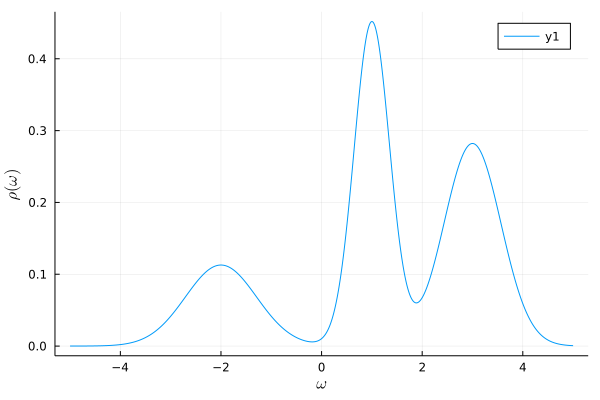

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#on-centered gaussian
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#rho(omega) = gaussian(omega, 1.0, 0.15) +
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

######

#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

#off-centered gaussian
#rho(omega) = gaussian(omega, 0.2, 0.05) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [5]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

38

In [6]:
setprecision(128)
;

In [7]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{T}(undef, hnw) 
;

In [8]:
# 元々倍精度のデータをString経由でBigFloatに変換すると精度が下がる
#for i in 1:hnw
    #test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    #test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
#end
for i in 1:hnw
    test_smpl[i]= IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [9]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H         =  8
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 71
println("N_imp $(N_imag)")
@time result    = Nevanlinna.Nevanlinna_Schur(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H, true)
opt_real = result[2]
;

N_imag is setted as 33
N_imp 33
Pick matrix is positive semi-definite.
Iter     Function value   Gradient norm 
     0     1.388255e-01     4.855332e-01
 * time: 0.029834985733032227
     1     1.124142e-01     3.775988e-01
 * time: 1.427109956741333
     2     7.243579e-02     2.838218e-01
 * time: 1.4659318923950195
     3     3.638893e-02     1.634163e-01
 * time: 1.5453369617462158
     4     1.124620e-02     5.134421e-02
 * time: 1.595094919204712
     5     7.218043e-03     3.293351e-02
 * time: 1.629922866821289
     6     3.814718e-03     3.103881e-02
 * time: 1.6850290298461914
     7     1.552301e-03     1.432012e-02
 * time: 1.7411530017852783
     8     1.095895e-03     4.637955e-03
 * time: 1.8196449279785156
     9     1.012484e-03     3.713669e-03
 * time: 1.882037878036499
    10     9.447584e-04     3.965103e-03
 * time: 1.9339449405670166
    11     8.460538e-04     5.099243e-03
 * time: 1.9797120094299316
    12     7.680026e-04     1.727517e-03
 * time: 2.0380189418

In [10]:
ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(N_imag, test_smpl, test_gw)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H)

Nevanlinna.evaluation(raw_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{MultiFloat{Float64, 2}}
RealDomainData{MultiFloat{Float64, 2}}
max_theta=0.0
hardy optimization was success.


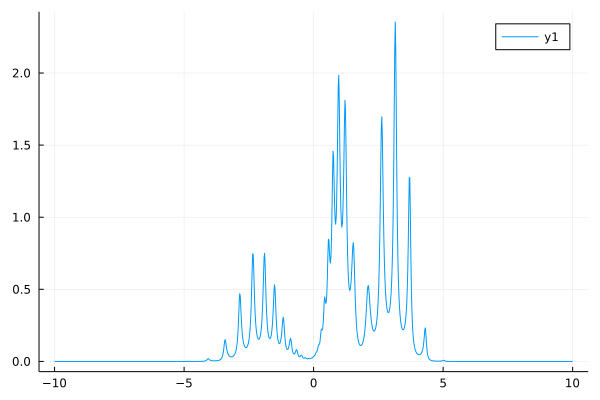

In [11]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))

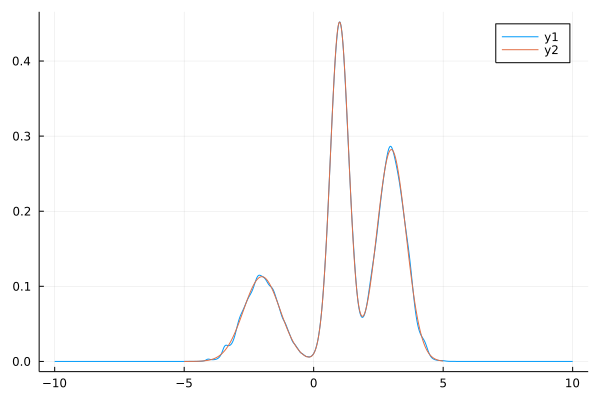

In [12]:
#plt.plot(Float64.(real.((opt_real.freq))), Float64.(imag.(opt_real.val))/pi)
#plt.plot(omegas, rho.(omegas))
#plt.xlim(-5,5)
plot()
plot!(Float64.(real.((opt_real.freq))), Float64.(imag.(opt_real.val))/pi)
plot!(omegas, rho.(omegas))

In [13]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [14]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#